In [114]:
import matplotlib.pyplot as plt
from scipy import spatial
import numpy as np

from importlib import reload

%reload_ext autoreload
%autoreload 2

import pyturb
reload(pyturb)

from time import sleep, perf_counter

import gc

In [115]:
# Tools to generate turbulent velocity fields
turb = pyturb.CreateTurbulentVelocityField(grid_size=64,v_turb=10.,box_size=10,seed=143289)
# Tools to measure velocity fields
mturb = pyturb.MeasureVelocityField()
# Tools to generate gridded velocity fields given particle data
gt = pyturb.GriddingTools()


In [117]:
resolution = [32, 64, 128, 256]
seed = np.ones(len(resolution),dtype=np.int64)*42
vel_field = [None]*len(resolution)
vel_field_smooth = [None]*len(resolution)

for i,res in enumerate(resolution):
    # Generate velocity field
    turb = pyturb.CreateTurbulentVelocityField(grid_size=res,v_turb=10.,box_size=10,seed=seed[i])    
    vel_field[i] = turb.generate_kolmogorov_field(energy_spectrum_index=5./3., energy_scale=1.0)
    # Generate a gridded version of the velocity field
    (vx,vy,vz) = (turb.vx.ravel(),turb.vy.ravel(),turb.vz.ravel())
    vel = np.stack([vx, vy, vz], axis=-1)
    (x,y,z) = (turb.X.ravel(),turb.Y.ravel(),turb.Z.ravel())
    pos = np.stack([x, y, z], axis=-1)
    grid_limits =  np.array([0,1,0,1,0,1], dtype=np.float64)*turb.box_size
    grid_size = [res,res,res]
    vel_field_smooth[i] = gt.smooth_to_grid(pos, vel, grid_size, grid_limits, method="CIC")

print("Finished generating velocity fields")


Finished generating velocity fields


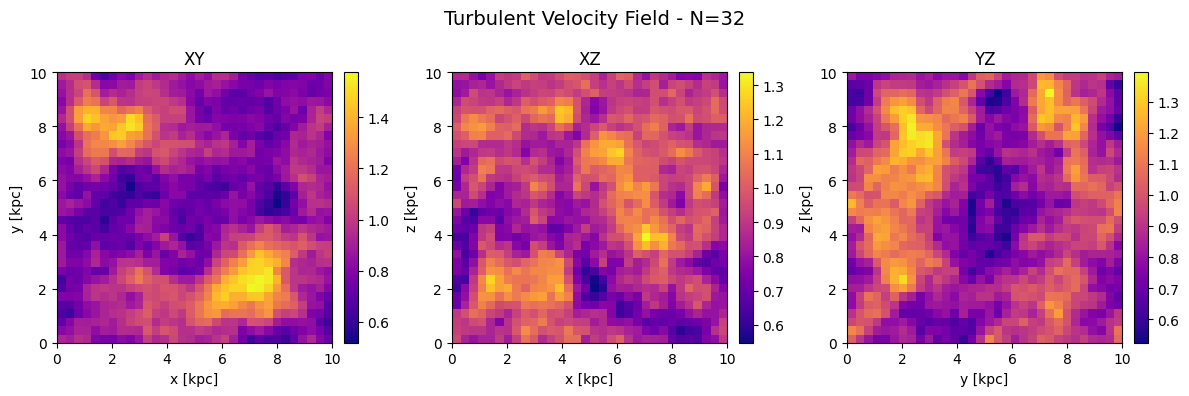

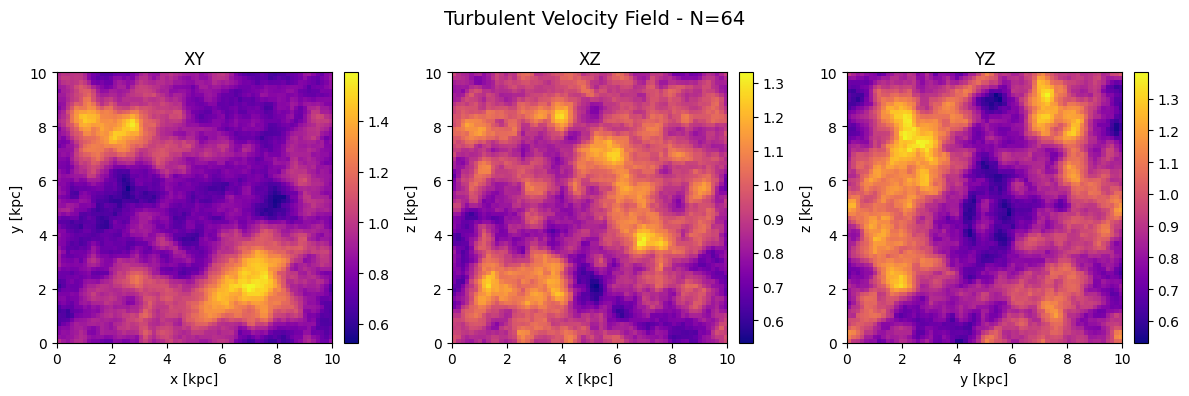

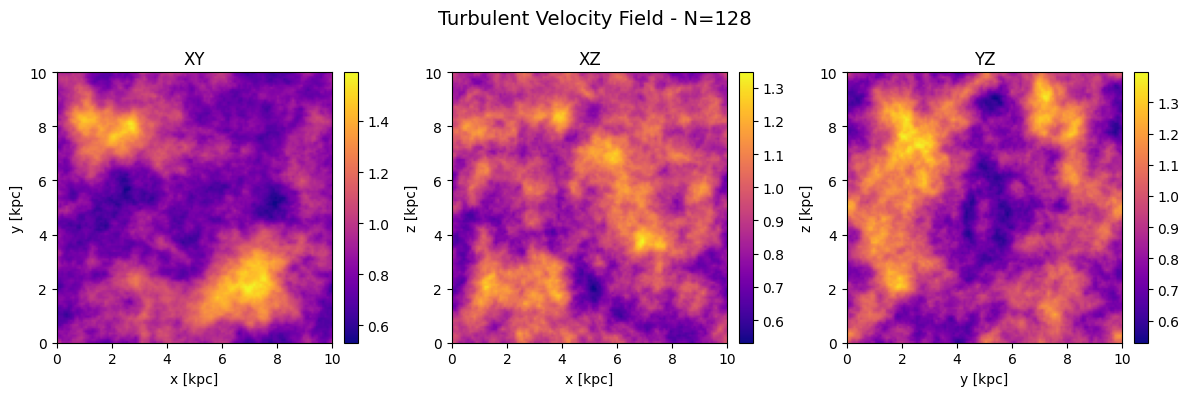

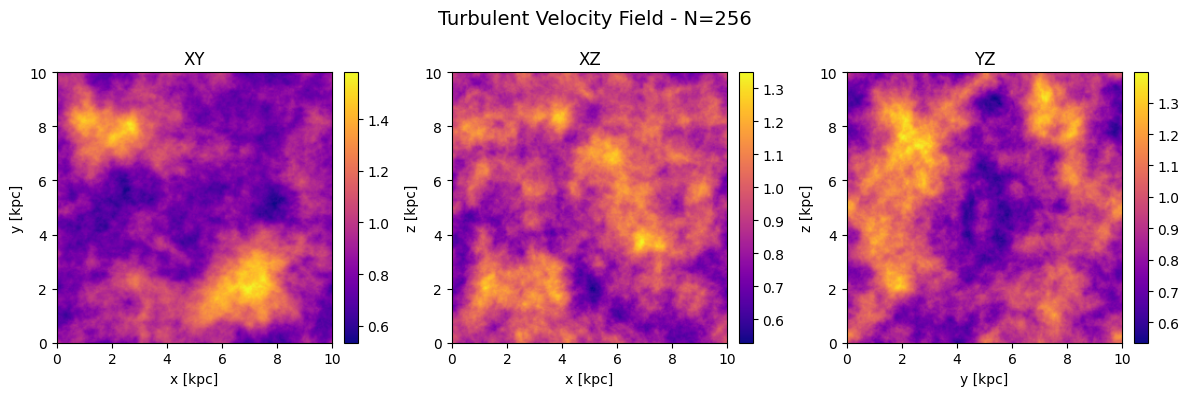

In [118]:
fig, axes = gt.plot_3d_projections(vel_field[0], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=32")
fig, axes = gt.plot_3d_projections(vel_field[1], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=64")
fig, axes = gt.plot_3d_projections(vel_field[2], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=128")
fig, axes = gt.plot_3d_projections(vel_field[3], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=256")

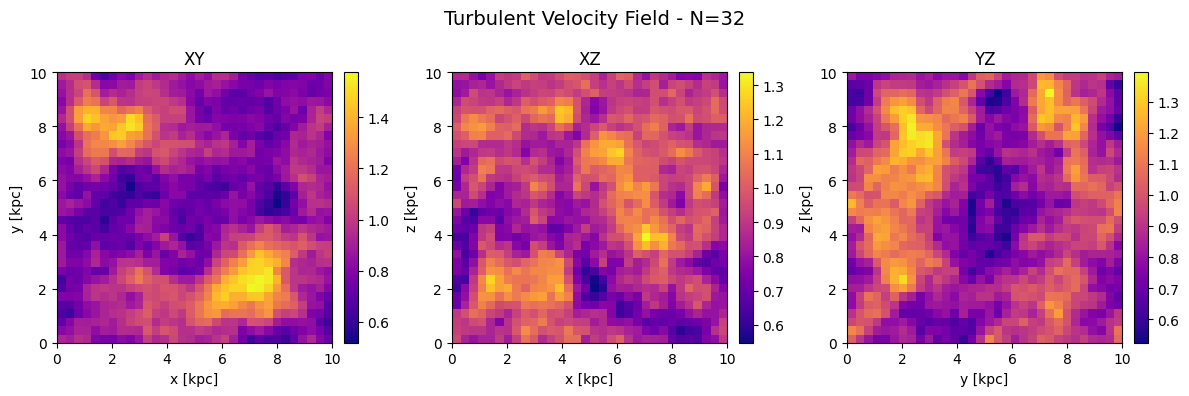

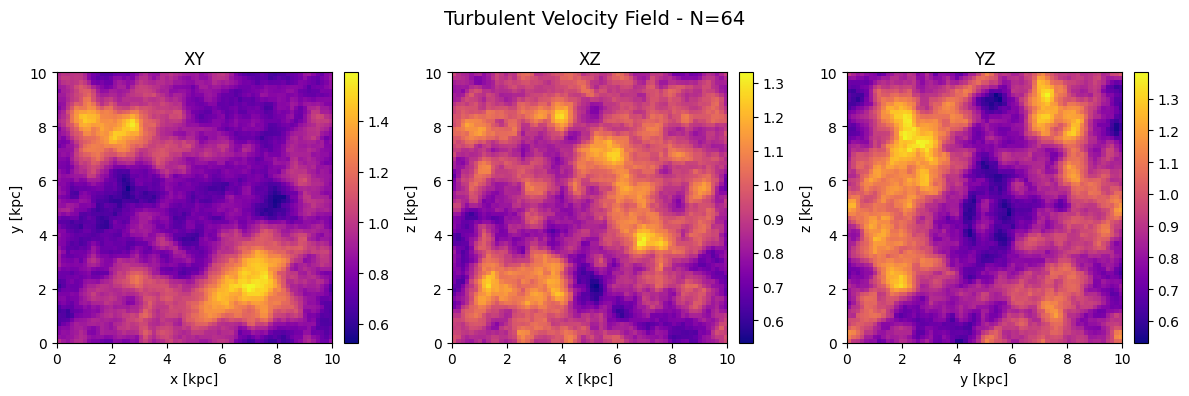

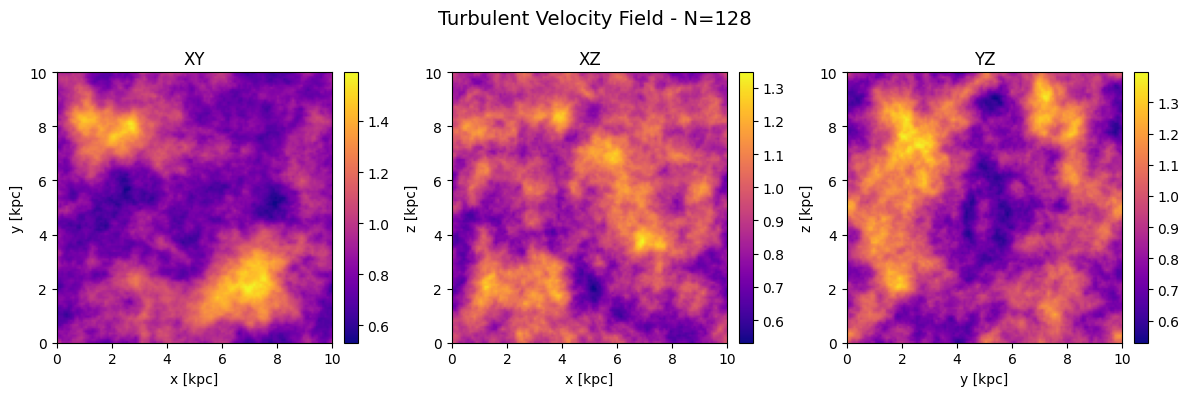

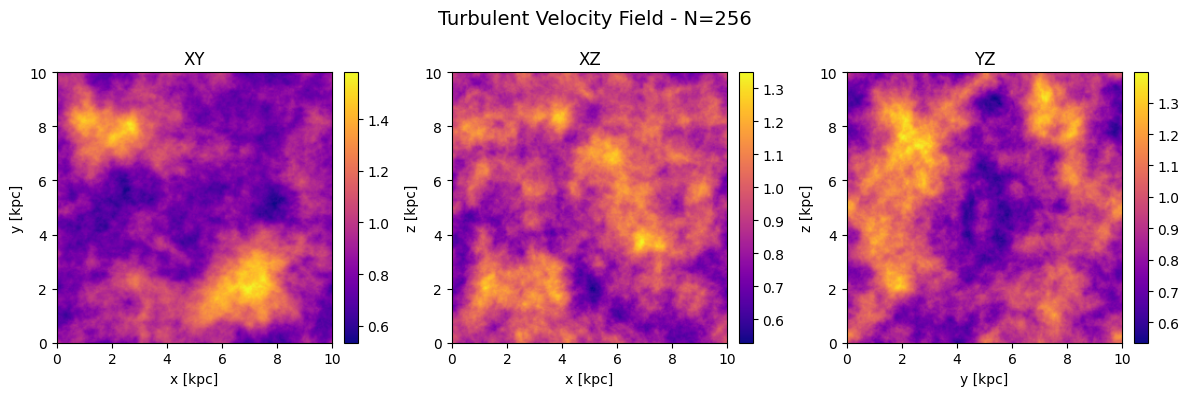

In [119]:
fig, axes = gt.plot_3d_projections(vel_field_smooth[0], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=32")
fig, axes = gt.plot_3d_projections(vel_field_smooth[1], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=64")
fig, axes = gt.plot_3d_projections(vel_field_smooth[2], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=128")
fig, axes = gt.plot_3d_projections(vel_field_smooth[3], grid_limits, mode='projection', slice_width=3, projection='mean', cmap='plasma', units='kpc', title="Turbulent Velocity Field - N=256")

In [121]:
# Compute for the velocity field generated by pyturb...
k0,pk0,_=mturb.compute_power_spectrum(vel_field[0], box_size=turb.box_size, component='energy', method='radial')
# ... and compute for the velocity field constructed from the positions and velocities
k1,pk1,_=mturb.compute_power_spectrum(vel_field[1], box_size=turb.box_size, component='energy', method='radial')
# ... and compute for the velocity field constructed from the positions and velocities
k2,pk2,_=mturb.compute_power_spectrum(vel_field[2], box_size=turb.box_size, component='energy', method='radial')
# ... and compute for the velocity field constructed from the positions and velocities
k3,pk3,_=mturb.compute_power_spectrum(vel_field[3], box_size=turb.box_size, component='energy', method='radial')


32768
1.7508335038883966 1.7508335038883969
262144
1.741224524421285 1.7412245244212852
2097152
1.736468098421335 1.7364680984213356
16777216
1.7336921325943888 1.7336921325943901


In [ ]:
# Compute for the velocity field generated by pyturb...
ks0,pks0,_=mturb.compute_power_spectrum(vel_field_smooth[0], box_size=turb.box_size, component='energy', method='radial')
# ... and compute for the velocity field constructed from the positions and velocities
ks1,pks1,_=mturb.compute_power_spectrum(vel_field_smooth[1], box_size=turb.box_size, component='energy', method='radial')
# ... and compute for the velocity field constructed from the positions and velocities
ks2,pks2,_=mturb.compute_power_spectrum(vel_field_smooth[2], box_size=turb.box_size, component='energy', method='radial')
# ... and compute for the velocity field constructed from the positions and velocities
ks3,pks3,_=mturb.compute_power_spectrum(vel_field_smooth[3], box_size=turb.box_size, component='energy', method='radial')


Measured power law slope: -3.581
Expected slope (Kolmogorov): -3.667
Difference: 0.086


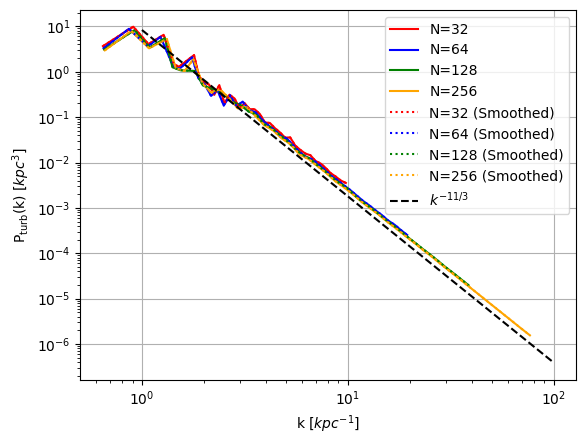

In [123]:
plt.xlabel(r"k [$kpc^{-1}$]")
plt.ylabel(r"P$_\text{turb}$(k) [$kpc^{3}$]")
plt.xscale("log")
plt.yscale("log")
plt.plot(k0,pk0,color="red",label="N=32")
plt.plot(k1,pk1,color="blue",label="N=64")
plt.plot(k2,pk2,color="green",label="N=128")
plt.plot(k3,pk3,color="orange",label="N=256")

plt.plot(k0,pk0,":",color="red",label="N=32 (Smoothed)")
plt.plot(k1,pk1,":",color="blue",label="N=64 (Smoothed)")
plt.plot(k2,pk2,":",color="green",label="N=128 (Smoothed)")
plt.plot(k3,pk3,":",color="orange",label="N=256 (Smoothed)")

plt.grid(True)
plt.legend()

fit_mask = (k3 > 10) & (k3 < 30)
if np.any(fit_mask):
    log_k_fit = np.log10(k3[fit_mask])
    log_P_fit = np.log10(pk3[fit_mask])
    slope, intercept = np.polyfit(log_k_fit, log_P_fit, 1)
        
print(f"Measured power law slope: {slope:.3f}")
print(f"Expected slope (Kolmogorov): {-11/3:.3f}")
print(f"Difference: {abs(slope + 11/3):.3f}")
    
# Add theoretical line
k_theory = np.logspace(0, 2, 50)
P_theory = k_theory**(-11/3)
P_theory *= pk3[10] / P_theory[10]  # Normalize
plt.plot(k_theory, P_theory, '--', color='black', label=r'$k^{-11/3}$')
plt.legend()



In [366]:
turb.write_to_file("./turbulent_ics.hdf5")


Created 262144 particles
Box size: 10 pc
Mean density: 1.0 H/cm^3
Initial temperature: 10000.0 K
Initial conditions written to ./turbulent_ics.hdf5
